In [ ]:
# The first part of this notebook is inspired by R. Labbe's work, the second by A. Bewley's.

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm

You should submit before the deadline a **TP_KalmanFilter_firstname-surname.zip** containing:
- The completed .ipynb notebook
- The completed kalman_filter.py, multiple_object_tracker.py and robot_simulation.py files

You do not need to attach the data nor the output of the last section on multiple object tracking as we must be able to regenerate the output by running your notebook.

# Introduction on Gaussian distributions

The Kalman filter is essentially a Bayesian filter that uses Gaussians. Let's see in 1D how we can use Gaussian distributions to encode priors about the location of a robot, and update them given measurements.

## Beliefs as Gaussians

In [ ]:
# Code the 1D Gaussian probability density function
def Gaussian_pdf(x, mean=0., variance=1.):
    """
    x: scalar or numpy.array
    Returns N(x|mean,variance), the scalar or numpy array containing the Gaussian pdf evaluated at x.
    """
    return norm.pdf(x=x, loc=mean, scale=np.sqrt(variance))

We can express our belief in the robot's position with a Gaussian. Say we believe that the robot is at 10 meters, and the variance in that belief is 1m$^2$, or $\mathcal{N}(10,\, 1)$. A plot of the pdf follows:

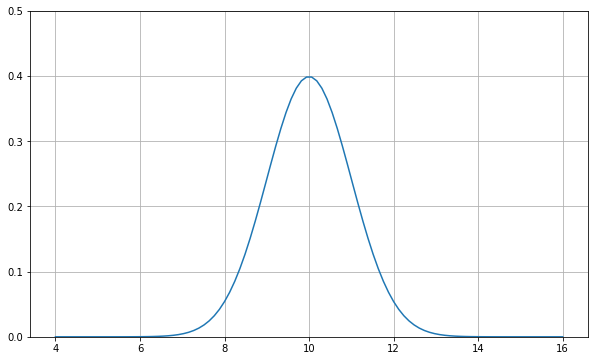

In [ ]:
xs = np.linspace(4, 16, 100)
ys = Gaussian_pdf(xs, mean=10.)

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')
plt.ylim(0,.5)
plt.grid(True)

This plot depicts our uncertainty about the robot's position. It represents a fairly inexact belief. While we believe that it is most likely that the robot is at 10 m, any position from 9 m to 11 m or so is quite likely as well.

## Predictions with Gaussians

Suppose starting from an uncertain position $x = \mathcal{N}(10,\, 1)$, the robot moves by an amount $\epsilon = \mathcal{N}(0,\, 0.5^2)$. How do we compute the prior for the new location of the robot, given that both their initial location and move are uncertain?

We make use of the fact that the sum of two independent Gaussians is again Gaussian, whose mean equals the sum of their means and whose variance equals the sum of their variance. In our case, this yields a prior $\bar{x}=\mathcal{N}(\bar\mu,\, \bar\sigma^2)$ with:

$$\begin{aligned}\bar\mu &= \mu_x + \mu_\epsilon = 10 + 0 &&= 10 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{\epsilon}^2 = 1^2 + 0.5^2 &&= 1.25\end{aligned}$$

It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, we don't really know where the robot is moving, so the confidence should get smaller (variance gets larger). $\sigma_{\epsilon}^2$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty.

Let's implement this:

In [ ]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [ ]:
# Implement the prediction update from above
def predict(pos, movement):
    """
    pos, movement: gaussian namedtuples
    Returns: a gaussian namedtuple
    """
    return gaussian(pos[0] + movement[0], pos[1] + movement[1])

In [ ]:
pos = gaussian(10., 1.**2)
move = gaussian(0, 0.5**2)
predict(pos, move)

𝒩(μ=10.000, 𝜎²=1.250)

The prior states that the robot is at 10 m with a variance of 1.25 m$^2$, which is what we computed by hand.

## Updates with Gaussians

The likelihood is the probability of the measurement given the current state. We can represent measurements as Gaussians. For example, maybe our sensor states that the robot is at 12 m, with a standard deviation of 0.5 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (12, 0.5^2)$.

Both the likelihood and prior are modeled with Gaussians. The update, a.k.a. the posterior, is obtained up to normalization by multiplying these Gaussians. After normalization, the product of these Gaussians is in turn a Gaussian $\mathcal N(\mu, \sigma^2)$ as per slides 44-45.

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &\propto prior \cdot likelihood \\
&= \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \\
&\propto \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

Let's implement this:

In [ ]:
# Implement the update obtained by multiplying prior and likelihood as in the formula above
def gaussian_multiply(g1, g2):
    """
    g1, g2: Gaussian namedtuples
    Returns: a Gaussian namedtuple that is (up to renormalization) the product of g1 and g2
    """
    return gaussian((g1[1]*g2[0] + g2[1]*g1[0]) / (g1[1] + g2[1]), (g1[1]*g2[1]) / (g1[1] + g2[1]))

def update(prior, likelihood):
    """
    prior, likelihood: Gaussian namedtuples
    Returns: a Gaussian namedtuple
    """
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [ ]:
# Test the update function
predicted_pos = gaussian(10., 1.25)
measured_pos = gaussian(12., 0.5**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=11.667, 𝜎²=0.208)

### Understanding Gaussian multiplication

Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

The shape will be gaussian too. According to the previous explainations (slides 44-45), it will have the same mean (10) and the variance should be smaller (1/2) so the curve will be narrower.

𝒩(μ=10.000, 𝜎²=0.500)


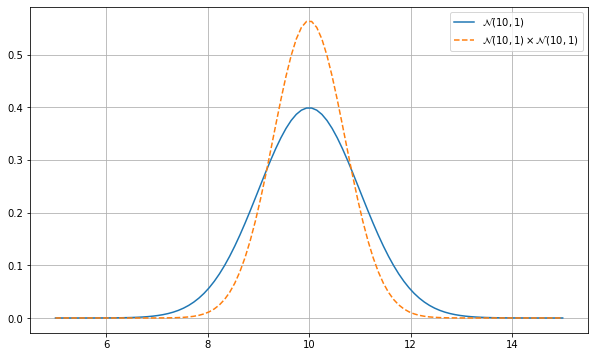

In [ ]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)
product = gaussian_multiply(z, z)

plt.figure(figsize=(10, 6))

xs = np.linspace(5, 15, 100)
ys = Gaussian_pdf(xs, z.mean, z.var)
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = Gaussian_pdf(xs, product.mean, product.var)
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
plt.grid(True)

print(product)

The result of the multiplication is taller and narrow than the original Gaussian but the mean is unchanged. Does this match your intuition?

Yes it is as we said. 

Now let's plot the pdf of $\mathcal{N}(10.4,\, 1) \times \mathcal{N}(9.6,\, 1)$. What do you think the result will be?

This time the mean will be a mean of the means (10), and the variance will be 1/2 so the curve will be narrower.

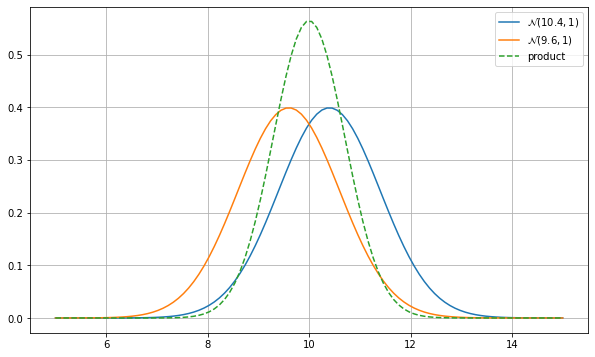

In [ ]:
def plot_products(g1, g2): 
    plt.figure(figsize=(10, 6))
    product = gaussian_multiply(g1, g2)

    xs = np.linspace(5, 15, 100)
    ys = Gaussian_pdf(xs, g1.mean, g1.var)
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = Gaussian_pdf(xs, g2.mean, g2.var)
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g2.mean},{g2.var})$')

    ys = Gaussian_pdf(xs, product.mean, product.var)
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    plt.grid(True)
    plt.show()
    
z1 = gaussian(10.4, 1)
z2 = gaussian(9.6, 1)
 
plot_products(z1, z2)

Finally, consider the case where one of the Gaussian distributions is much narrower than the other. Which of the means is closest to the mean of the resulting product distribution? Compare the width of the product Gaussian to the widths of the respective Gaussians forming the product.

The resulting mean will be closest to the one of the narrower distribution.

# Kalman filter tracking of robot trajectory

We will apply Kalman filtering to track the location of a robot in 1D. The robot moves during each time step and its new location is sensed with some measurement error. We will filter the noisy measurements to track the location over time.

You will assume the robot moves with constant velocity and implement a constant velocity state transition model. The state is thus 2-dimensional and consists of the location $x$ of the robot and its velocity $v$ (similar to slide 17 but in 1D). We assume measurements are acquired at time intervals of $\Delta t=1$s.

You first have to complete the KalmanFilter implementation in kalman_filter.py. It implements a general purpose Kalman filter as per the predict and update equations presented in the slides 47-50.

You then have to complete the code blocks below.

In [ ]:
import numpy as np


class KalmanFilter(object):
    """
    Implements a Kalman filter.
    
    
    Parameters:
    
    dim_x : int
        Number of state variables for the Kalman filter. For example, if
        you are tracking the position and velocity of an object in one
        dimension, dim_x would be 2.
    dim_z : int
        Number of measurement inputs. For example, if the sensor
        provides you with position in one dimension, dim_z would be 1.
        
        
    Attributes:
    
    x : numpy.array(dim_x, 1) (preferred) or numpy.array(dim_x,)
        Current state estimate. Any call to update() or predict() updates
        this variable.
    P : numpy.array(dim_x, dim_x)
        Current state covariance matrix. Any call to update() or predict()
        updates this variable.
    Q : numpy.array(dim_x, dim_x)
        Process noise covariance matrix. 
    R : numpy.array(dim_z, dim_z)
        Measurement noise covariance matrix.
    F : numpy.array(dim_x, dim_x)
        State Transition matrix.
    H : numpy.array(dim_z, dim_x)
        Measurement/observation matrix.
        
        
    You are responsible for initializing x and P to reasonable values (for instance x to 0 and large P), 
    as well as providing Q, R, F, H. 
    
    f = KalmanFilter(dim_x=..., dim_z=...)
    
    f.x = ...
    f.P = ...
    
    f.F = ...
    f.H = ...
    f.Q = ...
    f.R = ...
    
    Then using the filter will look like a succession of predict/update steps:
    
    while new time step:
        f.predict()
        z = read_measurement(...)
        f.update(z)

    """
    
    def __init__(self, dim_x, dim_z):
        if dim_x < 1:
            raise ValueError('dim_x must be 1 or greater')
        if dim_z < 1:
            raise ValueError('dim_z must be 1 or greater')
            
        self.dim_x = dim_x
        self.dim_z = dim_z
        
        # Initialize with zeros or identity when possible
        self.x = np.zeros((dim_x, 1))        # state (mean)
        self.P = np.eye(dim_x)        # uncertainty covariance
        self.Q = np.eye(dim_x)        # process uncertainty
        self.F = np.eye(dim_x)         # state transition matrix
        self.H = np.eye(dim_z, dim_x)       # measurement matrix
        self.R = np.eye(dim_z)         # measurement uncertainty        
    
    def predict(self, F=None, Q=None):
        """
        Predict next state (a priori) using the Kalman filter state transition equation
        
        F : np.array(dim_x, dim_x), or None
            Optional state transition matrix
        Q : np.array(dim_x, dim_x), or None
            Optional process noise matrix
            
        Returns: 
            Nothing, state self.x and covariance self.P are updated in place 
        """
        
        if F is None:
            F = self.F
        if Q is None:
            Q = self.Q
            
        # Mean update
        self.x = F @ self.x 
        
        # Covariance update
        self.P = F @ self.P @ F.T + Q
        
        
    def update(self, z, R=None, H=None):
        """
        Update the state (a posteriori) in response to a new measurement z.
        
        z : (dim_z, 1) or (dim_z,)
            measurement for this update.
        R : np.array(dim_z, dim_z), or None
            Optionally provide R to override the measurement noise for this
            one call.
        H : np.array(dim_z, dim_x), or None
            Optionally provide H to override the measurement matrix for this
            one call.
        
        Returns: 
            Nothing, state self.x and covariance self.P are updated in place 
        """
        
        if R is None:
            R = self.R

        if H is None:
            H = self.H
            
        # Innovation
        y = z - H @ self.x
        
        # Innovation covariance
        S = H @ self.P @ H.T + R
        
        # Kalman gain
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # New state mean
        self.x = self.x + K @ y
        
        # New state covariance (you can use the symmetric formula from slide 50 for stability)
        self.P = (np.eye(H.shape[1]) - K @ H) @ self.P

In [ ]:
class RobotSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_std=0.0,
                 process_std=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_std: standard deviation in measurement m
            process_std: standard deviation in process (m/s)
        """
        self.x = x0
        self.velocity = velocity
        self.measurement_std = measurement_std
        self.process_std = process_std

    def move(self, dt=1.0):
        """Compute new position of the walker in dt seconds."""
        dx = self.velocity + np.random.randn()*self.process_std
        self.x += dx * dt

    def locate(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + np.random.randn()*self.measurement_std
        return measurement

    def move_and_locate(self):
        """ Move robot, and return measurement of new position in meters"""
        self.move()
        return self.locate()

In [ ]:
# This code generates the (walk and) measurements at each of N timesteps spaced by a time interval of delta_t = 1.0

process_std = .5
measurement_std = 2.
N = 25

robot = RobotSimulation(0, 1.0, measurement_std, process_std)
zs = [np.array([robot.move_and_locate()]) for _ in range(N)] # Array of measurements at each time step

In [ ]:
# Initialize the Kalman filter
kf = KalmanFilter(2 ,N)

kf.x = np.zeros((2, 1)) # Initialize the location and velocity at 0
kf.P = np.array([[20**2, 0],
                 [0, 2**2]]) # Initialize the standard deviation of the location at 20. and the std of the velocity at 2.

kf.F = np.array([[1, 1],
                 [0, 1]]) # Set the transition matrix to that corresponding to a constant velocity model
kf.Q = np.array([[process_std**2, 0],
                 [0, 0.1**2]]) # Set the process noise std to process_std for the location and 0.1 for the velocity
kf.H = np.array([[1, 0]]) # Set the measurement matrix to only observe the location
kf.R = measurement_std ** 2 # Set the measurement std to measurement_std

# Run the Kalman filter at each timestep and store the predictions in the arrays below

priors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance
xs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance
vs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance 
xs[0,:] = np.array([kf.x[0], kf.P[0, 0]])
vs[0,:] = np.array([kf.x[1], kf.P[1, 1]])

for i, z in enumerate(zs):
    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs
    priors[i,:] = np.array([kf.x[0], kf.P[0, 0]])

    kf.predict()
    kf.update(z)

    xs[i+1,:] = np.array([kf.x[0], kf.P[0, 0]])
    vs[i+1,:] = np.array([kf.x[1], kf.P[1, 1]])

<ipython-input-31-b1f86bf23642>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs[0,:] = np.array([kf.x[0], kf.P[0, 0]])
<ipython-input-31-b1f86bf23642>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vs[0,:] = np.array([kf.x[1], kf.P[1, 1]])
<ipython-input-31-b1f86bf23642>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prio

In [ ]:
def plot_filter(xs, var, c='C0', **kwargs):
    ys = xs
    xs = range(len(ys))
   
    lines = plt.plot(xs, ys, color=c, label='Filter', **kwargs)
    
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

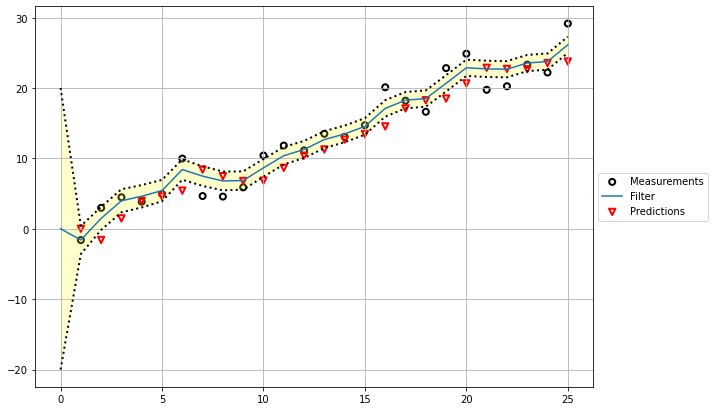

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(range(1,len(zs)+1), zs, edgecolor='k', facecolor='none',
                        lw=2, label='Measurements')
plot_filter(xs[:,0], xs[:,1])
plt.scatter(range(1,len(priors)+1), priors[:,0], marker='v', s=40, edgecolor='r',
                facecolor='None', lw=2, label='Predictions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

What can you say at each timestep of the position of the filtered estimate compared to the position of the measurement and of the prior?

**The predictions** are more stable than the measurements, which are sometimes really far from the previous measurement. The predictions seem to be influenced by the priors' position, but are more stable (they stay in the interval made by adding/substracting the std to the prior). The predicitions are an average of all the priors and measurments.

Print the standard deviation of the location before (a priori) and after (a posteriori) each measurement. What can you say about it? Compare to the measurement standard deviation.

In [ ]:
print(priors[:,1])
print(xs[:,1])

[400.           3.96080833   2.6949429    2.69182721   2.53602877
   2.31363117   2.10577479   1.93233039   1.79297721   1.68268665
   1.59611106   1.52862157   1.47641535   1.4364004    1.40605744
   1.38332687   1.36652496   1.35428191   1.34549401   1.33928384
   1.33496513   1.33201074   1.33002339   1.32870947   1.32785621]
[400.           3.96080833   2.6949429    2.69182721   2.53602877
   2.31363117   2.10577479   1.93233039   1.79297721   1.68268665
   1.59611106   1.52862157   1.47641535   1.4364004    1.40605744
   1.38332687   1.36652496   1.35428191   1.34549401   1.33928384
   1.33496513   1.33201074   1.33002339   1.32870947   1.32785621
   1.32731238]


We have exactly the same std... The measurement std is 2, and we can notice that the std a priori and a posterio are in 2+-1.

The robot model implemented in RobotSimulation is very close to the constant velocity model that we assume in the Kalman filter. As a variant, generate the walk according to a different robot model than the one proposed in RobotSimulation (for instance any function of time). Does the Kalman filter still behave adequately? If not, what could you change to improve its behaviour?

The Kalman filter still behaves adequatly (but the result is more linear) : 

In [ ]:
class RobotSimulation2(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_std=0.0,
                 process_std=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_std: standard deviation in measurement m
            process_std: standard deviation in process (m/s)
        """
        self.x = x0
        self.velocity = velocity
        self.measurement_std = measurement_std
        self.process_std = process_std

    def move(self, dt=1.0):
        """Compute new position of the walker in dt seconds."""
        dx = self.velocity + np.random.randn()*self.process_std
        self.x += (dx + dx/2) * dt

    def locate(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + np.random.randn()*self.measurement_std
        return measurement

    def move_and_locate(self):
        """ Move robot, and return measurement of new position in meters"""
        self.move()
        return self.locate()

In [ ]:
robot2 = RobotSimulation2(0, 1.0, measurement_std, process_std)
zs = [np.array([robot2.move_and_locate()]) for _ in range(N)] # Array of measurements at each time step

In [ ]:
# Initialize the Kalman filter
kf = KalmanFilter(2 ,N)

kf.x = np.zeros((2, 1)) # Initialize the location and velocity at 0
kf.P = np.array([[20**2, 0],
                 [0, 2**2]]) # Initialize the standard deviation of the location at 20. and the std of the velocity at 2.

kf.F = np.array([[1, 1],
                 [0, 1]]) # Set the transition matrix to that corresponding to a constant velocity model
kf.Q = np.array([[process_std**2, 0],
                 [0, 0.1**2]]) # Set the process noise std to process_std for the location and 0.1 for the velocity
kf.H = np.array([[1, 0]]) # Set the measurement matrix to only observe the location
kf.R = measurement_std ** 2 # Set the measurement std to measurement_std

# Run the Kalman filter at each timestep and store the predictions in the arrays below

priors = np.zeros((N, 2)) # store the prediction of the location before each measurement along with its variance
xs = np.zeros((N+1, 2)) # store the (initial location and the) prediction of the location after each measurement + its variance
vs = np.zeros((N+1, 2)) # store the (initial velocity and the) velocity after each measurement along with the predicted variance 
xs[0,:] = np.array([kf.x[0], kf.P[0, 0]])
vs[0,:] = np.array([kf.x[1], kf.P[1, 1]])

for i, z in enumerate(zs):
    # Run the predict/update steps of the Kalman filter and fill priors, xs and vs
    priors[i,:] = np.array([kf.x[0], kf.P[0, 0]])

    kf.predict()
    kf.update(z)

    xs[i+1,:] = np.array([kf.x[0], kf.P[0, 0]])
    vs[i+1,:] = np.array([kf.x[1], kf.P[1, 1]])

<ipython-input-47-b1f86bf23642>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs[0,:] = np.array([kf.x[0], kf.P[0, 0]])
<ipython-input-47-b1f86bf23642>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vs[0,:] = np.array([kf.x[1], kf.P[1, 1]])
<ipython-input-47-b1f86bf23642>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prio

In [ ]:
def plot_filter(xs, var, c='C0', **kwargs):
    ys = xs
    xs = range(len(ys))
   
    lines = plt.plot(xs, ys, color=c, label='Filter', **kwargs)
    
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

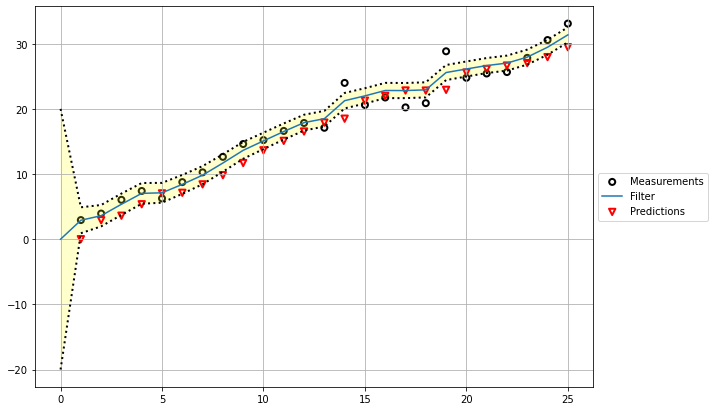

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(range(1,len(zs)+1), zs, edgecolor='k', facecolor='none',
                        lw=2, label='Measurements')
plot_filter(xs[:,0], xs[:,1])
plt.scatter(range(1,len(priors)+1), priors[:,0], marker='v', s=40, edgecolor='r',
                facecolor='None', lw=2, label='Predictions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Multiple Object Tracking

We now turn to multiple object tracking of pedestrians in video input, using the framework of tracking-by-detection as proposed in "Simple Online and Realtime Tracking" (Bewley et al., IEEE ICIP 2016). The gist of the framework is explained in slides 57-62.

On each new frame, a pedestrian detector is run to find the frame detections. Each detection is associated to an existing track, and new tracks are created for unmatched detections (unmatched tracks are deleted after a few frames without a match). Each individual track is maintained and updated by a Kalman filter.

In tracking-by-detection, object detectors are typically deep learning models. In this practical work, we will assume for convenience that detections are given to us rather than implementing or running a DL model. These are the columns 3 to 7 in the file 'data/KITTI-17_det.txt', where detection bounding boxes are in the format $[x1,y1,w,h]$, with $x1,y1$ the coordinates of the left-top corner, $w$ the width of the box and $h$ the height.

You can visualize what detections look like by opening the video 'data/KITTI-17_detections.webm' (you do not need this file in the remaining of the practical work).

The code presented here implements the other steps of track prediction, data association and track update. In this version, the Kalman filter maintains the bounding box in the form of the bounding box center coordinates $x,y$, the bounding box area $s$ (width$\times$height), and the aspect ration $r$ (width/height). In addition a constant velocity model is used on $x,y,s$ ($r$ is supposed constant). Therefore the internal state is 7-dimensional $[x,y,s,r,\dot{x},\dot{y},\dot{s}]$. As only the box location is measured, the noisy measurement is 4-dimensional: $[x,y,s,r]$.

We will reuse the Kalman filter that you have implemented in the previous part. Before running the cells below, you will have to fill in the missing lines in multiple_object_tracker.py:
- In iou_batch, implement the intersection-over-union of detected and tracked bounding boxes
- In convert_bbox_to_z and convert_x_to_bbox, fill in the missing lines
- In KalmanBoxTracker, fill in the missing parts in the init, predict and update member functions

You can test your iou_batch implementation using the cell below before running the multi-object tracker. After running the MOT, video frames with superimposed bounding boxes from tracked pedestrians are saved in 'output/images'. The last block of code uses opencv to convert these frames into a video saved in 'output/video.avi' for better visualization.

Optionally, you can test your code with a second video with detection file 'data/KITTI-13_det.txt' and frames in 'data/KITTI-13_img'

In [ ]:
#from types import UnionType
def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0]) #
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))


def iou_batch(bb_test, bb_gt):
    """
    Computes Intersection Over Union between two sets of bboxes in [x1,y1,x2,y2] format
    
    Arguments:
    bb_test: np.array(nb test boxes, 4)
    bb_gt: np.array(nb gt boxes, 4)
    
    Returns:
    IoU: np.array(nb test boxes, nb gt boxes), the IoU between all test and gt boxes
    """

    IoU = np.zeros((bb_test.shape[0], bb_gt.shape[0]))  

    for i in range(bb_test.shape[0]):
      for j in range(bb_gt.shape[0]):

        x1_test, y1_test, x2_test, y2_test = bb_test[i, :4]
        x_test = range(int(min(x1_test, x2_test)), int(max(x1_test, x2_test)))
        y_test = range(int(min(y1_test, y2_test)), int(max(y1_test, y2_test)))

        x1_gt, y1_gt, x2_gt, y2_gt = bb_gt[j, :4]
        x_gt = range(int(min(x1_gt, x2_gt)), int(max(x1_gt, x2_gt)))
        y_gt = range(int(min(y1_gt, y2_gt)), int(max(y1_gt, y2_gt)))

        interX = len(set(x_test) & set(x_gt))
        interY = len(set(y_test) & set(y_gt))
        interArea = interX * interY

        unionArea = abs(x2_test - x1_test) * abs(y2_test - y1_test) + abs(x2_gt - x1_gt) * abs(y2_gt - y1_gt) - interArea
        
        IoU[i, j] = interArea / unionArea

    return IoU  


def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the area and r is
    the aspect ratio
    """
    x1, y1, x2, y2 = bbox[:4]

    x = (max(x1, x2) + min(x1, x2)) / 2
    y = (max(y1, y2) + min(y1, y2)) / 2
    s = (max(x1, x2) - min(x1, x2)) * (max(y1, y2) - min(y1, y2))
    r = (max(x1, x2) - min(x1, x2)) / (max(y1, y2) - min(y1, y2))
    
    return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x, score=None):
    """
    Takes a bounding box x in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    xc, yc, s, r = x[:4]
    """
    2*xc = x1 + x2 -> x1 = 2*xc - x2
    2*yc = y1 + y2 -> y1 = 2*yc - y2
    s = (x2 - x1) * (y2 - y1) -> x2 - x1 = s / (y2 - y1) 
    r = (x2 - x1) / (y2 - y1) = (x2 - x1)² / s -> x2 - x1 = sqrt(s*r) = 2*(x2-xc) = 2*(xc-x1) ->  ou y2 - y1 = sqrt(s/r) 
    """
    width = np.sqrt(s*r)
    height = np.sqrt(s/r)
    x1 = xc - width / 2  
    y1 = yc - height / 2
    x2 = xc + width / 2  
    y2 = yc + height / 2
    
    if(score==None):
        return np.array([x1, y1, x2, y2]).reshape((1,4))
    else:
        return np.array([x1, y1, x2, y2, score]).reshape((1,5))


class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
        The state is in the form [[x,y,s,r,\dot{x},\dot{y},\dot{s}]]. 
        Only the first four dimensions are observed.
    """
    count = 0
    def __init__(self, bbox):
        """
        Initialises a tracker using initial bounding box.
            bbox is in the [x1,y1,x2,y2] format
        """

        # define a constant velocity model
        self.kf = KalmanFilter(7, 4) 
            # Initialize a KalmanFilter with the correct dimension for the state and measurement    
            
        # Initialize the state transition matrix and measurement matrix assuming a constant velocity model
        # with only location variables measured
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 1]])
        self.kf.H = np.eye(4, 7)

        self.kf.P[4:,4:] *= 1000. # give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01
        self.kf.R[2:,2:] *= 10.
        
        self.kf.x[:4] = convert_bbox_to_z(bbox)
        
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self, bbox):
        """
        Updates the state vector with observed bbox.
            bbox is in the [x1,y1,x2,y2] format
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        
        self.kf.update(convert_bbox_to_z(bbox)) # write the call to the Kalman filter update

    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
            self.kf.x[6] *= 0.0
            
        self.kf.predict() # write the call to the Kalman filter predict
        
        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)


def associate_detections_to_trackers(detections, trackers, iou_threshold = 0.3):
    """
    Assigns detections to tracked object (both represented as bounding boxes)
    Returns 3 lists of matches, unmatched_detections and unmatched_trackers
    """
    if(len(trackers)==0):
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0:
        a = (iou_matrix > iou_threshold).astype(np.int32)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1:
            matched_indices = np.stack(np.where(a), axis=1)
        else:
            matched_indices = linear_assignment(-iou_matrix)
    else:
        matched_indices = np.empty(shape=(0,2))

    unmatched_detections = []
    for d, det in enumerate(detections):
        if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t, trk in enumerate(trackers):
        if(t not in matched_indices[:,1]):
            unmatched_trackers.append(t)

    #filter out matched with low IOU
    matches = []
    for m in matched_indices:
        if(iou_matrix[m[0], m[1]]<iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


class MOT(object):
    def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
        """
        Sets key parameters for SORT
        """
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0

    def update(self, dets=np.empty((0, 5))):
        """
        Params:
          dets - a numpy array of detections in the format [[x1,y1,x2,y2,score], [x1,y1,x2,y2,score],...]
        Requires: this method must be called once for each frame even with empty detections 
        (use np.empty((0, 5)) for frames without detections).
        Returns a similar array, where the last column is the object ID.
        NOTE: The number of objects returned may differ from the number of detections provided.
        """
        self.frame_count += 1
        # get predicted locations from existing trackers.
        trks = np.zeros((len(self.trackers), 5))
        to_del = []
        ret = []
        for t, trk in enumerate(trks):
            pos = self.trackers[t].predict()[0]
            trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
            if np.any(np.isnan(pos)):
                to_del.append(t)
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
            self.trackers.pop(t)
        matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

        # update matched trackers with assigned detections
        for m in matched:
            self.trackers[m[1]].update(dets[m[0], :])

        # create and initialise new trackers for unmatched detections
        for i in unmatched_dets:
            trk = KalmanBoxTracker(dets[i,:])
            self.trackers.append(trk)
        i = len(self.trackers)
        for trk in reversed(self.trackers):
            d = trk.get_state()[0]
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
                ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
            i -= 1
            # remove dead tracklet
            if(trk.time_since_update > self.max_age):
                self.trackers.pop(i)
        if(len(ret)>0):
            return np.concatenate(ret)
        return np.empty((0,5))

In [ ]:
# To test your implementation of iou_batch
bb_test = np.array([[0,0,30,30],
                    [15,15,45,45]])
bb_gt = np.array([[0,0,30,30],
                  [15,15,45,45],
                  [30,30,60,60]])

iou_batch(bb_test, bb_gt)

# Output should be
# [[1, 1/7, 0],
#  [1/7, 1, 1/7]]

array([[1.        , 0.14285714, 0.        ],
       [0.14285714, 1.        , 0.14285714]])

Multiple Object Tracker on the video frames from 'data/KITTI-17_img':

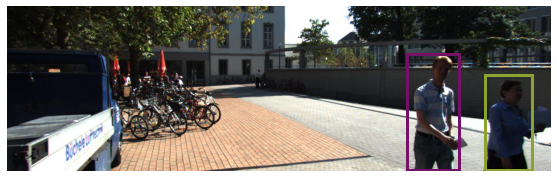

In [ ]:
# Initialize the multi object tracker
mot_tracker = MOT(max_age=1, min_hits=3, iou_threshold=0.3)

# Load all detections for all frames
dets = np.loadtxt(dets_filename, delimiter=',')

# Run the MOT over all frames, save png of all frames with tracked pedestrians
for frame in range(int(dets[:,0].max())):
    frame += 1 #detection and frame numbers begin at 1
    frame_dets = dets[dets[:, 0]==frame, 2:7]
    frame_dets[:, 2:4] += frame_dets[:, 0:2] #convert from [x1,y1,w,h] to [x1,y1,x2,y2]
    
    im = io.imread(os.path.join(img_path, '%06d.jpg'%(frame)))
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 10*im.shape[0]/im.shape[1]))
    ax1 = fig.add_subplot(111, aspect='equal')   
    ax1.imshow(im)   
    plt.grid(False)
    plt.axis('off')
    
    trackers = mot_tracker.update(frame_dets)
    
    for d in trackers:
        d = d.astype(np.int32)
        ax1.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colours[d[4]%32,:]))

    plt.savefig(os.path.join('output', 'images', str(frame).zfill(6) + '.png'))
    plt.show();

In [ ]:
import os
from skimage import io

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [ ]:
colours = np.random.rand(32, 3)
dets_filename = '/content/data/KITTI-17_det.txt'
img_path = os.path.join('data', 'KITTI-17_img')

if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/images'):
    os.makedirs('output/images')

In [ ]:
# Reload the png's and save as video for better visualization
import os
import cv2

image_folder = os.path.join('output', 'images')
video_name = os.path.join('output','video.avi')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

Optionally, you can test your code with a second video with detection file in 'data/KITTI-13_det.txt' and frames in 'data/KITTI-13_img'

In [ ]:
colours = np.random.rand(32, 3)
dets_filename = '/content/data/KITTI-13_det.txt'
img_path = os.path.join('data', 'KITTI-13_img')

if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/images'):
    os.makedirs('output/images')

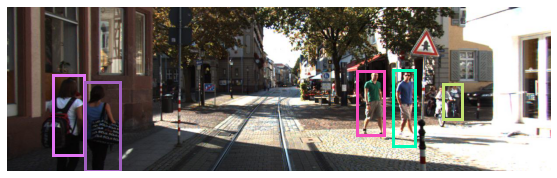

In [ ]:
# Initialize the multi object tracker
mot_tracker = MOT(max_age=1, min_hits=3, iou_threshold=0.3)

# Load all detections for all frames
dets = np.loadtxt(dets_filename, delimiter=',')

# Run the MOT over all frames, save png of all frames with tracked pedestrians
for frame in range(int(dets[:,0].max())):
    frame += 1 #detection and frame numbers begin at 1
    frame_dets = dets[dets[:, 0]==frame, 2:7]
    frame_dets[:, 2:4] += frame_dets[:, 0:2] #convert from [x1,y1,w,h] to [x1,y1,x2,y2]
    
    im = io.imread(os.path.join(img_path, '%06d.jpg'%(frame)))
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 10*im.shape[0]/im.shape[1]))
    ax1 = fig.add_subplot(111, aspect='equal')   
    ax1.imshow(im)   
    plt.grid(False)
    plt.axis('off')
    
    trackers = mot_tracker.update(frame_dets)
    
    for d in trackers:
        d = d.astype(np.int32)
        ax1.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colours[d[4]%32,:]))

    plt.savefig(os.path.join('output', 'images', str(frame).zfill(6) + '.png'))
    plt.show();

In [ ]:
# Reload the png's and save as video for better visualization
import os
import cv2

image_folder = os.path.join('output', 'images')
video_name = os.path.join('output','video2.avi')

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()